# Algorithms for Threat Detection Data
By Zhonghao Zhao and Bingxue An, under advise of Professor Bo Li

In [1]:
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import math
import warnings

In [2]:
# read data
data_number = [1,2,3]
dataset = pd.read_csv("DATA/"+ "AIS_Challenge_Problem_Set_0_"+ str(1) + "_withVID.csv")
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13714 entries, 0 to 13713
Data columns (total 7 columns):
OBJECT_ID             13714 non-null int64
VID                   13714 non-null int64
SEQUENCE_DTTM         13714 non-null object
LAT                   13714 non-null float64
LON                   13714 non-null float64
SPEED_OVER_GROUND     13714 non-null int64
COURSE_OVER_GROUND    13714 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 750.1+ KB


,OBJECT_ID,VID,SEQUENCE_DTTM,LAT,LON,SPEED_OVER_GROUND,COURSE_OVER_GROUND
0,1,100008,14:00:00,36.906850,-76.089022,1,1641
1,2,100015,14:00:00,36.950000,-76.026834,11,2815
2,3,100016,14:00:00,36.906783,-76.089084,0,2632
3,4,100019,14:00:00,37.003000,-76.283167,148,2460
4,5,100016,14:00:01,36.906783,-76.089084,0,2632


In [3]:
# A method to convert HH-MM-SS to seconds
def get_sec(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

# a node class for each data
class Vessel_node:
    def __init__(self, object_id, time, lat, lon, speed, direction, real_VID):
        self.OBJECT_ID = object_id
        self.VID = -1
        self.Time = time
        self.LAT = lat
        self.LON = lon
        self.Speed = speed*0.514444
        self.Direction = direction
        self.real_vid = real_VID
    
    def set_VID(self, vid):
        self.VID = vid
    
    def get_ID(self):
        return self.OBJECT_ID
    
    def get_real_vid(self):
        return self.real_vid
    
    def get_LAT(self):
        return self.LAT
    
    def get_LON(self):
        return self.LON
    
    def get_Time(self):
        return self.Time
    
    def get_SPEED(self):
        return self.Speed
    
    def get_DIRECTION(self):
        return self.Direction
    
# a track class to keep all tracks
class All_tracks:
    def __init__(self):
        self.tracks = []
        self.total_track = 0
        self.node_tracks = []
    
    def get_total_track(self):
        return self.total_track
        
    def add_track(self, node):
        new_track = [node.get_ID()]
        new_node_track = [node]
        self.total_track += 1
        node.set_VID(self.total_track)
        self.tracks.append(new_track)
        self.node_tracks.append(new_node_track) 
     
    def add_node(self, track_id, node):
        node.set_VID(track_id)
        self.tracks[track_id - 1].append(node.get_ID())
        self.node_tracks[track_id - 1].append(node)
    
    def print_track(self):
        for track in self.tracks:
            print(track)
            print('\n')
        
    def print_track_number(self):
        print(self.total_track)
    
    def get_node_track(self):
        return self.node_tracks
    
    def get_track_number(self):
        return self.total_track
    
    def get_tracks(self):
        return self.tracks
'''The initial assumption is the accleration is constant between two nodes, use v_1-v_0 / (t_1-t_0) to calculate 
the accleration, use v_0*t + 0.5*a*t^2 to calculate the desired final x, y location, then compare it with the final 
x, y location, calculate the desired distance difference sqrt (x_expect-x)^2 + (y_expect-y)^2 for every track, compare
it with the actual distane, using actual lon and lat to calculate
'''
def calculate_distance(lat2, lon2, lat1, lon1):
    R = 6371000; #earth radian
    l_1 = math.radians(lat1)
    l_2 = math.radians(lat2)
    lat_diff = math.radians(lat2-lat1)
    lon_diff = math.radians(lon2-lon1)
    temp = math.sin(lat_diff/2)**2 + math.cos(l_1) * math.cos(l_2) * math.sin(lon_diff/2)**2
    c = 2 * math.atan2(math.sqrt(temp), math.sqrt(1-temp))
    d = R * c
    return d

''' This function will return the distance error between two nodes with the input of these two nodes
    distance error is defined as the square of error of (expected distance - actual distance)

'''

' This function will return the distance error between two nodes with the input of these two nodes\n    distance error is defined as the square of error of (expected distance - actual distance)\n\n'

In [4]:
'''Organize new training dataset for ML, determing when to start new track
   1 stands the two nodes are in same track, 0 stands not.
'''

vid = []
train_tracker = All_tracks()
speed_1 = []
speed_2 = []
Time_1 = []
Time_2 = []
Lat_1 = []
Lat_2 = []
Lon_1 = []
Lon_2 = []
angle_1 = []
angle_2 = []

outcome = []
prev_row = 0
prev_node = 0
for index, row in dataset.iterrows():
    #sequencial compare in general
    cur_row = row.tolist()
    cur_node = Vessel_node(cur_row[0],get_sec(cur_row[2]), cur_row[3], cur_row[4], cur_row[5]/10, cur_row[6]/10, cur_row[1])
    cur_vid = cur_row[1]
    if(prev_row):
        if cur_vid != prev_row[1]:
            speed_1.append(prev_node.get_SPEED())
            speed_2.append(cur_node.get_SPEED())
            Time_1.append(prev_node.get_Time())
            Time_2.append(cur_node.get_Time())
            Lat_1.append(prev_node.get_LAT())
            Lat_2.append(cur_node.get_LAT())      
            Lon_1.append(prev_node.get_LON())
            Lon_2.append(cur_node.get_LON())
            angle_1.append(prev_node.get_DIRECTION())
            angle_2.append(cur_node.get_DIRECTION())
            outcome.append(0)
            
    prev_row = cur_row
    prev_node = cur_node
    
    #sequencial compare in same track
    if(vid and (cur_vid in vid)):
        node_tracks = train_tracker.get_node_track()
        for i in range(train_tracker.get_track_number()):
            cur_track = node_tracks[i]
            last = cur_track[-1]
            if(last.get_real_vid() == cur_vid):
                train_tracker.add_node(i+1, cur_node)
                speed_1.append(last.get_SPEED())
                speed_2.append(cur_node.get_SPEED())
                Time_1.append(last.get_Time())
                Time_2.append(cur_node.get_Time())
                Lat_1.append(last.get_LAT())
                Lat_2.append(cur_node.get_LAT())      
                Lon_1.append(last.get_LON())
                Lon_2.append(cur_node.get_LON())
                angle_1.append(last.get_DIRECTION())
                angle_2.append(cur_node.get_DIRECTION())
                outcome.append(1)
            else:
                continue
    
    if(cur_vid not in vid):
        vid.append(cur_vid)
        train_tracker.add_track(cur_node)
        
"""
see whether we get a balanced training dataset 
"""
count_0 = 0
count_1 = 0
for item in outcome:
    if item == 0:
        count_0 += 1
    else:
        count_1 += 1
        
print(count_0, count_1)

13188 13694


In [5]:
zippedList =  list(zip(speed_1, speed_2, Time_1, Time_2, Lat_1, Lat_2, Lon_1, Lon_2, angle_1, angle_2,outcome))  
new_dataframe = pd.DataFrame(zippedList, columns = ["speed_1", "speed_2", "Time_1", "Time_2", "Lat_1", "Lat_2", "Lon_1", "Lon_2", 
                                                    "angle_1", "angle_2","outcome"])

In [6]:
new_dataframe.head()

,speed_1,speed_2,Time_1,Time_2,Lat_1,Lat_2,Lon_1,Lon_2,angle_1,angle_2,outcome
0,0.051444,0.565888,50400,50400,36.906850,36.950000,-76.089022,-76.026834,164.1,281.5,0
1,0.565888,0.000000,50400,50400,36.950000,36.906783,-76.026834,-76.089084,281.5,263.2,0
2,0.000000,7.613771,50400,50400,36.906783,37.003000,-76.089084,-76.283167,263.2,246.0,0
3,7.613771,0.000000,50400,50401,37.003000,36.906783,-76.283167,-76.089084,246.0,263.2,0
4,0.000000,0.000000,50400,50401,36.906783,36.906783,-76.089084,-76.089084,263.2,263.2,1


In [7]:
response = np.asarray(outcome)
print(response)

[0 0 0 ... 1 0 1]


In [8]:
#k fold cross validation, k = 10, 0 not same track, 1 same
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier # Import Random Forest Classifier
from sklearn.model_selection import train_test_split
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
randomForest_scores = []
best_randomForest = 0
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(new_dataframe.drop(['outcome'], axis = "columns"),
                                                        response, test_size = 0.2)
    model = RandomForestClassifier(n_estimators= 20)
    model.fit(X_train, y_train)
    current_score_r = model.score(X_test,y_test)
    if not randomForest_scores or current_score_r > max(randomForest_scores):
        best_randomForest = model
    randomForest_scores.append(current_score_r)

In [12]:
from sklearn.metrics import confusion_matrix
y_pred = best_randomForest.predict(X_test)
print(confusion_matrix(y_pred, y_test))
best_randomForest.score(X_test,y_test)

[[2654    1]
 [   5 2717]]


0.9988841361353915

In [13]:
feature_importances = pd.DataFrame(best_randomForest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

         importance
Lon_2      0.180649
Lon_1      0.161741
Lat_1      0.159505
Lat_2      0.136044
speed_1    0.095537
angle_1    0.087533
angle_2    0.075199
speed_2    0.072626
Time_2     0.016296
Time_1     0.014870


In [14]:
''' This function will return the distance error between two nodes with the input of these two nodes
    distance error is defined as the square of error of (expected distance - actual distance)

'''

def calculate_DE(node_a, node_b):
    a = node_a
    b = node_b
    angle_1 = math.radians(a.get_DIRECTION())
    angle_2 = math.radians(b.get_DIRECTION())
    v_diff_x = b.get_SPEED()*math.cos(angle_2) - a.get_SPEED()*math.cos(angle_1)
    v_diff_y = b.get_SPEED()*math.sin(angle_2) - a.get_SPEED()*math.sin(angle_1)
    t_diff = b.get_Time()- a.get_Time()
    acc_x = v_diff_x / t_diff
    acc_y = v_diff_y / t_diff
    lon_diff_expect = a.get_SPEED()*math.cos(angle_1)*t_diff + 0.5*acc_x*t_diff**2
    lat_diff_expect = a.get_SPEED()*math.sin(angle_1)*t_diff + 0.5*acc_y*t_diff**2
    total_diff = math.sqrt(lon_diff_expect**2 + lat_diff_expect**2)
    d = calculate_distance(b.get_LAT(), b.get_LON(), a.get_LAT(), b.get_LON())
    error = (abs(d)-abs(total_diff))**2
    return error

def sortSecond(val): 
    return val[1]  

new_tracker = All_tracks()
K = 3
for index, row in dataset.iterrows():
    a = row.tolist()
    cur_node = Vessel_node(a[0],get_sec(a[2]), a[3], a[4], a[5]/10, a[6]/10,a[1])
    print(">>> processing row " + str(index))
    if(index == 0):
        new_tracker.add_track(cur_node)
    else:
        all_possible = []
        node_tracks = new_tracker.get_node_track()
        for i in range(new_tracker.get_track_number()):
            each_track = node_tracks[i]
            for j in range(1,K+1):
                if(len(each_track) >= j):
                    last_node = each_track[-j]
                    if(last_node.get_Time() != cur_node.get_Time()):
                        df = [[last_node.get_SPEED(), cur_node.get_SPEED(), last_node.get_Time(), cur_node.get_Time(), 
                        last_node.get_LAT(), cur_node.get_LAT(), last_node.get_LON(), cur_node.get_LON(), last_node.get_DIRECTION(),
                        cur_node.get_DIRECTION()]]
                        if best_randomForest.predict(df) == 1:
                            error = calculate_DE(last_node, cur_node)
                            all_possible.append((i+1, error))
                              
        if not all_possible:
            new_tracker.add_track(cur_node)
        else:
            all_possible.sort(key = sortSecond)
            new_tracker.add_node(all_possible[0][0], cur_node)

new_tracker.print_track_number()

>>> processing row 0
>>> processing row 1
>>> processing row 2
>>> processing row 3
>>> processing row 4
>>> processing row 5
>>> processing row 6
>>> processing row 7
>>> processing row 8
>>> processing row 9
>>> processing row 10
>>> processing row 11
>>> processing row 12
>>> processing row 13
>>> processing row 14
>>> processing row 15
>>> processing row 16
>>> processing row 17
>>> processing row 18
>>> processing row 19
>>> processing row 20
>>> processing row 21
>>> processing row 22
>>> processing row 23
>>> processing row 24
>>> processing row 25
>>> processing row 26
>>> processing row 27
>>> processing row 28
>>> processing row 29
>>> processing row 30
>>> processing row 31
>>> processing row 32
>>> processing row 33
>>> processing row 34
>>> processing row 35
>>> processing row 36
>>> processing row 37
>>> processing row 38
>>> processing row 39
>>> processing row 40
>>> processing row 41
>>> processing row 42
>>> processing row 43
>>> processing row 44
>>> processing row 4

>>> processing row 364
>>> processing row 365
>>> processing row 366
>>> processing row 367
>>> processing row 368
>>> processing row 369
>>> processing row 370
>>> processing row 371
>>> processing row 372
>>> processing row 373
>>> processing row 374
>>> processing row 375
>>> processing row 376
>>> processing row 377
>>> processing row 378
>>> processing row 379
>>> processing row 380
>>> processing row 381
>>> processing row 382
>>> processing row 383
>>> processing row 384
>>> processing row 385
>>> processing row 386
>>> processing row 387
>>> processing row 388
>>> processing row 389
>>> processing row 390
>>> processing row 391
>>> processing row 392
>>> processing row 393
>>> processing row 394
>>> processing row 395
>>> processing row 396
>>> processing row 397
>>> processing row 398
>>> processing row 399
>>> processing row 400
>>> processing row 401
>>> processing row 402
>>> processing row 403
>>> processing row 404
>>> processing row 405
>>> processing row 406
>>> process

>>> processing row 722
>>> processing row 723
>>> processing row 724
>>> processing row 725
>>> processing row 726
>>> processing row 727
>>> processing row 728
>>> processing row 729
>>> processing row 730
>>> processing row 731
>>> processing row 732
>>> processing row 733
>>> processing row 734
>>> processing row 735
>>> processing row 736
>>> processing row 737
>>> processing row 738
>>> processing row 739
>>> processing row 740
>>> processing row 741
>>> processing row 742
>>> processing row 743
>>> processing row 744
>>> processing row 745
>>> processing row 746
>>> processing row 747
>>> processing row 748
>>> processing row 749
>>> processing row 750
>>> processing row 751
>>> processing row 752
>>> processing row 753
>>> processing row 754
>>> processing row 755
>>> processing row 756
>>> processing row 757
>>> processing row 758
>>> processing row 759
>>> processing row 760
>>> processing row 761
>>> processing row 762
>>> processing row 763
>>> processing row 764
>>> process

>>> processing row 1077
>>> processing row 1078
>>> processing row 1079
>>> processing row 1080
>>> processing row 1081
>>> processing row 1082
>>> processing row 1083
>>> processing row 1084
>>> processing row 1085
>>> processing row 1086
>>> processing row 1087
>>> processing row 1088
>>> processing row 1089
>>> processing row 1090
>>> processing row 1091
>>> processing row 1092
>>> processing row 1093
>>> processing row 1094
>>> processing row 1095
>>> processing row 1096
>>> processing row 1097
>>> processing row 1098
>>> processing row 1099
>>> processing row 1100
>>> processing row 1101
>>> processing row 1102
>>> processing row 1103
>>> processing row 1104
>>> processing row 1105
>>> processing row 1106
>>> processing row 1107
>>> processing row 1108
>>> processing row 1109
>>> processing row 1110
>>> processing row 1111
>>> processing row 1112
>>> processing row 1113
>>> processing row 1114
>>> processing row 1115
>>> processing row 1116
>>> processing row 1117
>>> processing r

>>> processing row 1419
>>> processing row 1420
>>> processing row 1421
>>> processing row 1422
>>> processing row 1423
>>> processing row 1424
>>> processing row 1425
>>> processing row 1426
>>> processing row 1427
>>> processing row 1428
>>> processing row 1429
>>> processing row 1430
>>> processing row 1431
>>> processing row 1432
>>> processing row 1433
>>> processing row 1434
>>> processing row 1435
>>> processing row 1436
>>> processing row 1437
>>> processing row 1438
>>> processing row 1439
>>> processing row 1440
>>> processing row 1441
>>> processing row 1442
>>> processing row 1443
>>> processing row 1444
>>> processing row 1445
>>> processing row 1446
>>> processing row 1447
>>> processing row 1448
>>> processing row 1449
>>> processing row 1450
>>> processing row 1451
>>> processing row 1452
>>> processing row 1453
>>> processing row 1454
>>> processing row 1455
>>> processing row 1456
>>> processing row 1457
>>> processing row 1458
>>> processing row 1459
>>> processing r

>>> processing row 1761
>>> processing row 1762
>>> processing row 1763
>>> processing row 1764
>>> processing row 1765
>>> processing row 1766
>>> processing row 1767
>>> processing row 1768
>>> processing row 1769
>>> processing row 1770
>>> processing row 1771
>>> processing row 1772
>>> processing row 1773
>>> processing row 1774
>>> processing row 1775
>>> processing row 1776
>>> processing row 1777
>>> processing row 1778
>>> processing row 1779
>>> processing row 1780
>>> processing row 1781
>>> processing row 1782
>>> processing row 1783
>>> processing row 1784
>>> processing row 1785
>>> processing row 1786
>>> processing row 1787
>>> processing row 1788
>>> processing row 1789
>>> processing row 1790
>>> processing row 1791
>>> processing row 1792
>>> processing row 1793
>>> processing row 1794
>>> processing row 1795
>>> processing row 1796
>>> processing row 1797
>>> processing row 1798
>>> processing row 1799
>>> processing row 1800
>>> processing row 1801
>>> processing r

>>> processing row 2104
>>> processing row 2105
>>> processing row 2106
>>> processing row 2107
>>> processing row 2108
>>> processing row 2109
>>> processing row 2110
>>> processing row 2111
>>> processing row 2112
>>> processing row 2113
>>> processing row 2114
>>> processing row 2115
>>> processing row 2116
>>> processing row 2117
>>> processing row 2118
>>> processing row 2119
>>> processing row 2120
>>> processing row 2121
>>> processing row 2122
>>> processing row 2123
>>> processing row 2124
>>> processing row 2125
>>> processing row 2126
>>> processing row 2127
>>> processing row 2128
>>> processing row 2129
>>> processing row 2130
>>> processing row 2131
>>> processing row 2132
>>> processing row 2133
>>> processing row 2134
>>> processing row 2135
>>> processing row 2136
>>> processing row 2137
>>> processing row 2138
>>> processing row 2139
>>> processing row 2140
>>> processing row 2141
>>> processing row 2142
>>> processing row 2143
>>> processing row 2144
>>> processing r

>>> processing row 2448
>>> processing row 2449
>>> processing row 2450
>>> processing row 2451
>>> processing row 2452
>>> processing row 2453
>>> processing row 2454
>>> processing row 2455
>>> processing row 2456
>>> processing row 2457
>>> processing row 2458
>>> processing row 2459
>>> processing row 2460
>>> processing row 2461
>>> processing row 2462
>>> processing row 2463
>>> processing row 2464
>>> processing row 2465
>>> processing row 2466
>>> processing row 2467
>>> processing row 2468
>>> processing row 2469
>>> processing row 2470
>>> processing row 2471
>>> processing row 2472
>>> processing row 2473
>>> processing row 2474
>>> processing row 2475
>>> processing row 2476
>>> processing row 2477
>>> processing row 2478
>>> processing row 2479
>>> processing row 2480
>>> processing row 2481
>>> processing row 2482
>>> processing row 2483
>>> processing row 2484
>>> processing row 2485
>>> processing row 2486
>>> processing row 2487
>>> processing row 2488
>>> processing r

>>> processing row 2792
>>> processing row 2793
>>> processing row 2794
>>> processing row 2795
>>> processing row 2796
>>> processing row 2797
>>> processing row 2798
>>> processing row 2799
>>> processing row 2800
>>> processing row 2801
>>> processing row 2802
>>> processing row 2803
>>> processing row 2804
>>> processing row 2805
>>> processing row 2806
>>> processing row 2807
>>> processing row 2808
>>> processing row 2809
>>> processing row 2810
>>> processing row 2811
>>> processing row 2812
>>> processing row 2813
>>> processing row 2814
>>> processing row 2815
>>> processing row 2816
>>> processing row 2817
>>> processing row 2818
>>> processing row 2819
>>> processing row 2820
>>> processing row 2821
>>> processing row 2822
>>> processing row 2823
>>> processing row 2824
>>> processing row 2825
>>> processing row 2826
>>> processing row 2827
>>> processing row 2828
>>> processing row 2829
>>> processing row 2830
>>> processing row 2831
>>> processing row 2832
>>> processing r

>>> processing row 3135
>>> processing row 3136
>>> processing row 3137
>>> processing row 3138
>>> processing row 3139
>>> processing row 3140
>>> processing row 3141
>>> processing row 3142
>>> processing row 3143
>>> processing row 3144
>>> processing row 3145
>>> processing row 3146
>>> processing row 3147
>>> processing row 3148
>>> processing row 3149
>>> processing row 3150
>>> processing row 3151
>>> processing row 3152
>>> processing row 3153
>>> processing row 3154
>>> processing row 3155
>>> processing row 3156
>>> processing row 3157
>>> processing row 3158
>>> processing row 3159
>>> processing row 3160
>>> processing row 3161
>>> processing row 3162
>>> processing row 3163
>>> processing row 3164
>>> processing row 3165
>>> processing row 3166
>>> processing row 3167
>>> processing row 3168
>>> processing row 3169
>>> processing row 3170
>>> processing row 3171
>>> processing row 3172
>>> processing row 3173
>>> processing row 3174
>>> processing row 3175
>>> processing r

>>> processing row 3478
>>> processing row 3479
>>> processing row 3480
>>> processing row 3481
>>> processing row 3482
>>> processing row 3483
>>> processing row 3484
>>> processing row 3485
>>> processing row 3486
>>> processing row 3487
>>> processing row 3488
>>> processing row 3489
>>> processing row 3490
>>> processing row 3491
>>> processing row 3492
>>> processing row 3493
>>> processing row 3494
>>> processing row 3495
>>> processing row 3496
>>> processing row 3497
>>> processing row 3498
>>> processing row 3499
>>> processing row 3500
>>> processing row 3501
>>> processing row 3502
>>> processing row 3503
>>> processing row 3504
>>> processing row 3505
>>> processing row 3506
>>> processing row 3507
>>> processing row 3508
>>> processing row 3509
>>> processing row 3510
>>> processing row 3511
>>> processing row 3512
>>> processing row 3513
>>> processing row 3514
>>> processing row 3515
>>> processing row 3516
>>> processing row 3517
>>> processing row 3518
>>> processing r

>>> processing row 3820
>>> processing row 3821
>>> processing row 3822
>>> processing row 3823
>>> processing row 3824
>>> processing row 3825
>>> processing row 3826
>>> processing row 3827
>>> processing row 3828
>>> processing row 3829
>>> processing row 3830
>>> processing row 3831
>>> processing row 3832
>>> processing row 3833
>>> processing row 3834
>>> processing row 3835
>>> processing row 3836
>>> processing row 3837
>>> processing row 3838
>>> processing row 3839
>>> processing row 3840
>>> processing row 3841
>>> processing row 3842
>>> processing row 3843
>>> processing row 3844
>>> processing row 3845
>>> processing row 3846
>>> processing row 3847
>>> processing row 3848
>>> processing row 3849
>>> processing row 3850
>>> processing row 3851
>>> processing row 3852
>>> processing row 3853
>>> processing row 3854
>>> processing row 3855
>>> processing row 3856
>>> processing row 3857
>>> processing row 3858
>>> processing row 3859
>>> processing row 3860
>>> processing r

>>> processing row 4162
>>> processing row 4163
>>> processing row 4164
>>> processing row 4165
>>> processing row 4166
>>> processing row 4167
>>> processing row 4168
>>> processing row 4169
>>> processing row 4170
>>> processing row 4171
>>> processing row 4172
>>> processing row 4173
>>> processing row 4174
>>> processing row 4175
>>> processing row 4176
>>> processing row 4177
>>> processing row 4178
>>> processing row 4179
>>> processing row 4180
>>> processing row 4181
>>> processing row 4182
>>> processing row 4183
>>> processing row 4184
>>> processing row 4185
>>> processing row 4186
>>> processing row 4187
>>> processing row 4188
>>> processing row 4189
>>> processing row 4190
>>> processing row 4191
>>> processing row 4192
>>> processing row 4193
>>> processing row 4194
>>> processing row 4195
>>> processing row 4196
>>> processing row 4197
>>> processing row 4198
>>> processing row 4199
>>> processing row 4200
>>> processing row 4201
>>> processing row 4202
>>> processing r

>>> processing row 4506
>>> processing row 4507
>>> processing row 4508
>>> processing row 4509
>>> processing row 4510
>>> processing row 4511
>>> processing row 4512
>>> processing row 4513
>>> processing row 4514
>>> processing row 4515
>>> processing row 4516
>>> processing row 4517
>>> processing row 4518
>>> processing row 4519
>>> processing row 4520
>>> processing row 4521
>>> processing row 4522
>>> processing row 4523
>>> processing row 4524
>>> processing row 4525
>>> processing row 4526
>>> processing row 4527
>>> processing row 4528
>>> processing row 4529
>>> processing row 4530
>>> processing row 4531
>>> processing row 4532
>>> processing row 4533
>>> processing row 4534
>>> processing row 4535
>>> processing row 4536
>>> processing row 4537
>>> processing row 4538
>>> processing row 4539
>>> processing row 4540
>>> processing row 4541
>>> processing row 4542
>>> processing row 4543
>>> processing row 4544
>>> processing row 4545
>>> processing row 4546
>>> processing r

>>> processing row 4848
>>> processing row 4849
>>> processing row 4850
>>> processing row 4851
>>> processing row 4852
>>> processing row 4853
>>> processing row 4854
>>> processing row 4855
>>> processing row 4856
>>> processing row 4857
>>> processing row 4858
>>> processing row 4859
>>> processing row 4860
>>> processing row 4861
>>> processing row 4862
>>> processing row 4863
>>> processing row 4864
>>> processing row 4865
>>> processing row 4866
>>> processing row 4867
>>> processing row 4868
>>> processing row 4869
>>> processing row 4870
>>> processing row 4871
>>> processing row 4872
>>> processing row 4873
>>> processing row 4874
>>> processing row 4875
>>> processing row 4876
>>> processing row 4877
>>> processing row 4878
>>> processing row 4879
>>> processing row 4880
>>> processing row 4881
>>> processing row 4882
>>> processing row 4883
>>> processing row 4884
>>> processing row 4885
>>> processing row 4886
>>> processing row 4887
>>> processing row 4888
>>> processing r

>>> processing row 5191
>>> processing row 5192
>>> processing row 5193
>>> processing row 5194
>>> processing row 5195
>>> processing row 5196
>>> processing row 5197
>>> processing row 5198
>>> processing row 5199
>>> processing row 5200
>>> processing row 5201
>>> processing row 5202
>>> processing row 5203
>>> processing row 5204
>>> processing row 5205
>>> processing row 5206
>>> processing row 5207
>>> processing row 5208
>>> processing row 5209
>>> processing row 5210
>>> processing row 5211
>>> processing row 5212
>>> processing row 5213
>>> processing row 5214
>>> processing row 5215
>>> processing row 5216
>>> processing row 5217
>>> processing row 5218
>>> processing row 5219
>>> processing row 5220
>>> processing row 5221
>>> processing row 5222
>>> processing row 5223
>>> processing row 5224
>>> processing row 5225
>>> processing row 5226
>>> processing row 5227
>>> processing row 5228
>>> processing row 5229
>>> processing row 5230
>>> processing row 5231
>>> processing r

>>> processing row 5534
>>> processing row 5535
>>> processing row 5536
>>> processing row 5537
>>> processing row 5538
>>> processing row 5539
>>> processing row 5540
>>> processing row 5541
>>> processing row 5542
>>> processing row 5543
>>> processing row 5544
>>> processing row 5545
>>> processing row 5546
>>> processing row 5547
>>> processing row 5548
>>> processing row 5549
>>> processing row 5550
>>> processing row 5551
>>> processing row 5552
>>> processing row 5553
>>> processing row 5554
>>> processing row 5555
>>> processing row 5556
>>> processing row 5557
>>> processing row 5558
>>> processing row 5559
>>> processing row 5560
>>> processing row 5561
>>> processing row 5562
>>> processing row 5563
>>> processing row 5564
>>> processing row 5565
>>> processing row 5566
>>> processing row 5567
>>> processing row 5568
>>> processing row 5569
>>> processing row 5570
>>> processing row 5571
>>> processing row 5572
>>> processing row 5573
>>> processing row 5574
>>> processing r

>>> processing row 5876
>>> processing row 5877
>>> processing row 5878
>>> processing row 5879
>>> processing row 5880
>>> processing row 5881
>>> processing row 5882
>>> processing row 5883
>>> processing row 5884
>>> processing row 5885
>>> processing row 5886
>>> processing row 5887
>>> processing row 5888
>>> processing row 5889
>>> processing row 5890
>>> processing row 5891
>>> processing row 5892
>>> processing row 5893
>>> processing row 5894
>>> processing row 5895
>>> processing row 5896
>>> processing row 5897
>>> processing row 5898
>>> processing row 5899
>>> processing row 5900
>>> processing row 5901
>>> processing row 5902
>>> processing row 5903
>>> processing row 5904
>>> processing row 5905
>>> processing row 5906
>>> processing row 5907
>>> processing row 5908
>>> processing row 5909
>>> processing row 5910
>>> processing row 5911
>>> processing row 5912
>>> processing row 5913
>>> processing row 5914
>>> processing row 5915
>>> processing row 5916
>>> processing r

>>> processing row 6219
>>> processing row 6220
>>> processing row 6221
>>> processing row 6222
>>> processing row 6223
>>> processing row 6224
>>> processing row 6225
>>> processing row 6226
>>> processing row 6227
>>> processing row 6228
>>> processing row 6229
>>> processing row 6230
>>> processing row 6231
>>> processing row 6232
>>> processing row 6233
>>> processing row 6234
>>> processing row 6235
>>> processing row 6236
>>> processing row 6237
>>> processing row 6238
>>> processing row 6239
>>> processing row 6240
>>> processing row 6241
>>> processing row 6242
>>> processing row 6243
>>> processing row 6244
>>> processing row 6245
>>> processing row 6246
>>> processing row 6247
>>> processing row 6248
>>> processing row 6249
>>> processing row 6250
>>> processing row 6251
>>> processing row 6252
>>> processing row 6253
>>> processing row 6254
>>> processing row 6255
>>> processing row 6256
>>> processing row 6257
>>> processing row 6258
>>> processing row 6259
>>> processing r

>>> processing row 6562
>>> processing row 6563
>>> processing row 6564
>>> processing row 6565
>>> processing row 6566
>>> processing row 6567
>>> processing row 6568
>>> processing row 6569
>>> processing row 6570
>>> processing row 6571
>>> processing row 6572
>>> processing row 6573
>>> processing row 6574
>>> processing row 6575
>>> processing row 6576
>>> processing row 6577
>>> processing row 6578
>>> processing row 6579
>>> processing row 6580
>>> processing row 6581
>>> processing row 6582
>>> processing row 6583
>>> processing row 6584
>>> processing row 6585
>>> processing row 6586
>>> processing row 6587
>>> processing row 6588
>>> processing row 6589
>>> processing row 6590
>>> processing row 6591
>>> processing row 6592
>>> processing row 6593
>>> processing row 6594
>>> processing row 6595
>>> processing row 6596
>>> processing row 6597
>>> processing row 6598
>>> processing row 6599
>>> processing row 6600
>>> processing row 6601
>>> processing row 6602
>>> processing r

>>> processing row 6905
>>> processing row 6906
>>> processing row 6907
>>> processing row 6908
>>> processing row 6909
>>> processing row 6910
>>> processing row 6911
>>> processing row 6912
>>> processing row 6913
>>> processing row 6914
>>> processing row 6915
>>> processing row 6916
>>> processing row 6917
>>> processing row 6918
>>> processing row 6919
>>> processing row 6920
>>> processing row 6921
>>> processing row 6922
>>> processing row 6923
>>> processing row 6924
>>> processing row 6925
>>> processing row 6926
>>> processing row 6927
>>> processing row 6928
>>> processing row 6929
>>> processing row 6930
>>> processing row 6931
>>> processing row 6932
>>> processing row 6933
>>> processing row 6934
>>> processing row 6935
>>> processing row 6936
>>> processing row 6937
>>> processing row 6938
>>> processing row 6939
>>> processing row 6940
>>> processing row 6941
>>> processing row 6942
>>> processing row 6943
>>> processing row 6944
>>> processing row 6945
>>> processing r

>>> processing row 7248
>>> processing row 7249
>>> processing row 7250
>>> processing row 7251
>>> processing row 7252
>>> processing row 7253
>>> processing row 7254
>>> processing row 7255
>>> processing row 7256
>>> processing row 7257
>>> processing row 7258
>>> processing row 7259
>>> processing row 7260
>>> processing row 7261
>>> processing row 7262
>>> processing row 7263
>>> processing row 7264
>>> processing row 7265
>>> processing row 7266
>>> processing row 7267
>>> processing row 7268
>>> processing row 7269
>>> processing row 7270
>>> processing row 7271
>>> processing row 7272
>>> processing row 7273
>>> processing row 7274
>>> processing row 7275
>>> processing row 7276
>>> processing row 7277
>>> processing row 7278
>>> processing row 7279
>>> processing row 7280
>>> processing row 7281
>>> processing row 7282
>>> processing row 7283
>>> processing row 7284
>>> processing row 7285
>>> processing row 7286
>>> processing row 7287
>>> processing row 7288
>>> processing r

>>> processing row 7590
>>> processing row 7591
>>> processing row 7592
>>> processing row 7593
>>> processing row 7594
>>> processing row 7595
>>> processing row 7596
>>> processing row 7597
>>> processing row 7598
>>> processing row 7599
>>> processing row 7600
>>> processing row 7601
>>> processing row 7602
>>> processing row 7603
>>> processing row 7604
>>> processing row 7605
>>> processing row 7606
>>> processing row 7607
>>> processing row 7608
>>> processing row 7609
>>> processing row 7610
>>> processing row 7611
>>> processing row 7612
>>> processing row 7613
>>> processing row 7614
>>> processing row 7615
>>> processing row 7616
>>> processing row 7617
>>> processing row 7618
>>> processing row 7619
>>> processing row 7620
>>> processing row 7621
>>> processing row 7622
>>> processing row 7623
>>> processing row 7624
>>> processing row 7625
>>> processing row 7626
>>> processing row 7627
>>> processing row 7628
>>> processing row 7629
>>> processing row 7630
>>> processing r

>>> processing row 7932
>>> processing row 7933
>>> processing row 7934
>>> processing row 7935
>>> processing row 7936
>>> processing row 7937
>>> processing row 7938
>>> processing row 7939
>>> processing row 7940
>>> processing row 7941
>>> processing row 7942
>>> processing row 7943
>>> processing row 7944
>>> processing row 7945
>>> processing row 7946
>>> processing row 7947
>>> processing row 7948
>>> processing row 7949
>>> processing row 7950
>>> processing row 7951
>>> processing row 7952
>>> processing row 7953
>>> processing row 7954
>>> processing row 7955
>>> processing row 7956
>>> processing row 7957
>>> processing row 7958
>>> processing row 7959
>>> processing row 7960
>>> processing row 7961
>>> processing row 7962
>>> processing row 7963
>>> processing row 7964
>>> processing row 7965
>>> processing row 7966
>>> processing row 7967
>>> processing row 7968
>>> processing row 7969
>>> processing row 7970
>>> processing row 7971
>>> processing row 7972
>>> processing r

>>> processing row 8276
>>> processing row 8277
>>> processing row 8278
>>> processing row 8279
>>> processing row 8280
>>> processing row 8281
>>> processing row 8282
>>> processing row 8283
>>> processing row 8284
>>> processing row 8285
>>> processing row 8286
>>> processing row 8287
>>> processing row 8288
>>> processing row 8289
>>> processing row 8290
>>> processing row 8291
>>> processing row 8292
>>> processing row 8293
>>> processing row 8294
>>> processing row 8295
>>> processing row 8296
>>> processing row 8297
>>> processing row 8298
>>> processing row 8299
>>> processing row 8300
>>> processing row 8301
>>> processing row 8302
>>> processing row 8303
>>> processing row 8304
>>> processing row 8305
>>> processing row 8306
>>> processing row 8307
>>> processing row 8308
>>> processing row 8309
>>> processing row 8310
>>> processing row 8311
>>> processing row 8312
>>> processing row 8313
>>> processing row 8314
>>> processing row 8315
>>> processing row 8316
>>> processing r

>>> processing row 8619
>>> processing row 8620
>>> processing row 8621
>>> processing row 8622
>>> processing row 8623
>>> processing row 8624
>>> processing row 8625
>>> processing row 8626
>>> processing row 8627
>>> processing row 8628
>>> processing row 8629
>>> processing row 8630
>>> processing row 8631
>>> processing row 8632
>>> processing row 8633
>>> processing row 8634
>>> processing row 8635
>>> processing row 8636
>>> processing row 8637
>>> processing row 8638
>>> processing row 8639
>>> processing row 8640
>>> processing row 8641
>>> processing row 8642
>>> processing row 8643
>>> processing row 8644
>>> processing row 8645
>>> processing row 8646
>>> processing row 8647
>>> processing row 8648
>>> processing row 8649
>>> processing row 8650
>>> processing row 8651
>>> processing row 8652
>>> processing row 8653
>>> processing row 8654
>>> processing row 8655
>>> processing row 8656
>>> processing row 8657
>>> processing row 8658
>>> processing row 8659
>>> processing r

>>> processing row 8963
>>> processing row 8964
>>> processing row 8965
>>> processing row 8966
>>> processing row 8967
>>> processing row 8968
>>> processing row 8969
>>> processing row 8970
>>> processing row 8971
>>> processing row 8972
>>> processing row 8973
>>> processing row 8974
>>> processing row 8975
>>> processing row 8976
>>> processing row 8977
>>> processing row 8978
>>> processing row 8979
>>> processing row 8980
>>> processing row 8981
>>> processing row 8982
>>> processing row 8983
>>> processing row 8984
>>> processing row 8985
>>> processing row 8986
>>> processing row 8987
>>> processing row 8988
>>> processing row 8989
>>> processing row 8990
>>> processing row 8991
>>> processing row 8992
>>> processing row 8993
>>> processing row 8994
>>> processing row 8995
>>> processing row 8996
>>> processing row 8997
>>> processing row 8998
>>> processing row 8999
>>> processing row 9000
>>> processing row 9001
>>> processing row 9002
>>> processing row 9003
>>> processing r

>>> processing row 9305
>>> processing row 9306
>>> processing row 9307
>>> processing row 9308
>>> processing row 9309
>>> processing row 9310
>>> processing row 9311
>>> processing row 9312
>>> processing row 9313
>>> processing row 9314
>>> processing row 9315
>>> processing row 9316
>>> processing row 9317
>>> processing row 9318
>>> processing row 9319
>>> processing row 9320
>>> processing row 9321
>>> processing row 9322
>>> processing row 9323
>>> processing row 9324
>>> processing row 9325
>>> processing row 9326
>>> processing row 9327
>>> processing row 9328
>>> processing row 9329
>>> processing row 9330
>>> processing row 9331
>>> processing row 9332
>>> processing row 9333
>>> processing row 9334
>>> processing row 9335
>>> processing row 9336
>>> processing row 9337
>>> processing row 9338
>>> processing row 9339
>>> processing row 9340
>>> processing row 9341
>>> processing row 9342
>>> processing row 9343
>>> processing row 9344
>>> processing row 9345
>>> processing r

>>> processing row 9648
>>> processing row 9649
>>> processing row 9650
>>> processing row 9651
>>> processing row 9652
>>> processing row 9653
>>> processing row 9654
>>> processing row 9655
>>> processing row 9656
>>> processing row 9657
>>> processing row 9658
>>> processing row 9659
>>> processing row 9660
>>> processing row 9661
>>> processing row 9662
>>> processing row 9663
>>> processing row 9664
>>> processing row 9665
>>> processing row 9666
>>> processing row 9667
>>> processing row 9668
>>> processing row 9669
>>> processing row 9670
>>> processing row 9671
>>> processing row 9672
>>> processing row 9673
>>> processing row 9674
>>> processing row 9675
>>> processing row 9676
>>> processing row 9677
>>> processing row 9678
>>> processing row 9679
>>> processing row 9680
>>> processing row 9681
>>> processing row 9682
>>> processing row 9683
>>> processing row 9684
>>> processing row 9685
>>> processing row 9686
>>> processing row 9687
>>> processing row 9688
>>> processing r

>>> processing row 9991
>>> processing row 9992
>>> processing row 9993
>>> processing row 9994
>>> processing row 9995
>>> processing row 9996
>>> processing row 9997
>>> processing row 9998
>>> processing row 9999
>>> processing row 10000
>>> processing row 10001
>>> processing row 10002
>>> processing row 10003
>>> processing row 10004
>>> processing row 10005
>>> processing row 10006
>>> processing row 10007
>>> processing row 10008
>>> processing row 10009
>>> processing row 10010
>>> processing row 10011
>>> processing row 10012
>>> processing row 10013
>>> processing row 10014
>>> processing row 10015
>>> processing row 10016
>>> processing row 10017
>>> processing row 10018
>>> processing row 10019
>>> processing row 10020
>>> processing row 10021
>>> processing row 10022
>>> processing row 10023
>>> processing row 10024
>>> processing row 10025
>>> processing row 10026
>>> processing row 10027
>>> processing row 10028
>>> processing row 10029
>>> processing row 10030
>>> proce

>>> processing row 10319
>>> processing row 10320
>>> processing row 10321
>>> processing row 10322
>>> processing row 10323
>>> processing row 10324
>>> processing row 10325
>>> processing row 10326
>>> processing row 10327
>>> processing row 10328
>>> processing row 10329
>>> processing row 10330
>>> processing row 10331
>>> processing row 10332
>>> processing row 10333
>>> processing row 10334
>>> processing row 10335
>>> processing row 10336
>>> processing row 10337
>>> processing row 10338
>>> processing row 10339
>>> processing row 10340
>>> processing row 10341
>>> processing row 10342
>>> processing row 10343
>>> processing row 10344
>>> processing row 10345
>>> processing row 10346
>>> processing row 10347
>>> processing row 10348
>>> processing row 10349
>>> processing row 10350
>>> processing row 10351
>>> processing row 10352
>>> processing row 10353
>>> processing row 10354
>>> processing row 10355
>>> processing row 10356
>>> processing row 10357
>>> processing row 10358


>>> processing row 10647
>>> processing row 10648
>>> processing row 10649
>>> processing row 10650
>>> processing row 10651
>>> processing row 10652
>>> processing row 10653
>>> processing row 10654
>>> processing row 10655
>>> processing row 10656
>>> processing row 10657
>>> processing row 10658
>>> processing row 10659
>>> processing row 10660
>>> processing row 10661
>>> processing row 10662
>>> processing row 10663
>>> processing row 10664
>>> processing row 10665
>>> processing row 10666
>>> processing row 10667
>>> processing row 10668
>>> processing row 10669
>>> processing row 10670
>>> processing row 10671
>>> processing row 10672
>>> processing row 10673
>>> processing row 10674
>>> processing row 10675
>>> processing row 10676
>>> processing row 10677
>>> processing row 10678
>>> processing row 10679
>>> processing row 10680
>>> processing row 10681
>>> processing row 10682
>>> processing row 10683
>>> processing row 10684
>>> processing row 10685
>>> processing row 10686


>>> processing row 10976
>>> processing row 10977
>>> processing row 10978
>>> processing row 10979
>>> processing row 10980
>>> processing row 10981
>>> processing row 10982
>>> processing row 10983
>>> processing row 10984
>>> processing row 10985
>>> processing row 10986
>>> processing row 10987
>>> processing row 10988
>>> processing row 10989
>>> processing row 10990
>>> processing row 10991
>>> processing row 10992
>>> processing row 10993
>>> processing row 10994
>>> processing row 10995
>>> processing row 10996
>>> processing row 10997
>>> processing row 10998
>>> processing row 10999
>>> processing row 11000
>>> processing row 11001
>>> processing row 11002
>>> processing row 11003
>>> processing row 11004
>>> processing row 11005
>>> processing row 11006
>>> processing row 11007
>>> processing row 11008
>>> processing row 11009
>>> processing row 11010
>>> processing row 11011
>>> processing row 11012
>>> processing row 11013
>>> processing row 11014
>>> processing row 11015


>>> processing row 11305
>>> processing row 11306
>>> processing row 11307
>>> processing row 11308
>>> processing row 11309
>>> processing row 11310
>>> processing row 11311
>>> processing row 11312
>>> processing row 11313
>>> processing row 11314
>>> processing row 11315
>>> processing row 11316
>>> processing row 11317
>>> processing row 11318
>>> processing row 11319
>>> processing row 11320
>>> processing row 11321
>>> processing row 11322
>>> processing row 11323
>>> processing row 11324
>>> processing row 11325
>>> processing row 11326
>>> processing row 11327
>>> processing row 11328
>>> processing row 11329
>>> processing row 11330
>>> processing row 11331
>>> processing row 11332
>>> processing row 11333
>>> processing row 11334
>>> processing row 11335
>>> processing row 11336
>>> processing row 11337
>>> processing row 11338
>>> processing row 11339
>>> processing row 11340
>>> processing row 11341
>>> processing row 11342
>>> processing row 11343
>>> processing row 11344


>>> processing row 11633
>>> processing row 11634
>>> processing row 11635
>>> processing row 11636
>>> processing row 11637
>>> processing row 11638
>>> processing row 11639
>>> processing row 11640
>>> processing row 11641
>>> processing row 11642
>>> processing row 11643
>>> processing row 11644
>>> processing row 11645
>>> processing row 11646
>>> processing row 11647
>>> processing row 11648
>>> processing row 11649
>>> processing row 11650
>>> processing row 11651
>>> processing row 11652
>>> processing row 11653
>>> processing row 11654
>>> processing row 11655
>>> processing row 11656
>>> processing row 11657
>>> processing row 11658
>>> processing row 11659
>>> processing row 11660
>>> processing row 11661
>>> processing row 11662
>>> processing row 11663
>>> processing row 11664
>>> processing row 11665
>>> processing row 11666
>>> processing row 11667
>>> processing row 11668
>>> processing row 11669
>>> processing row 11670
>>> processing row 11671
>>> processing row 11672


>>> processing row 11963
>>> processing row 11964
>>> processing row 11965
>>> processing row 11966
>>> processing row 11967
>>> processing row 11968
>>> processing row 11969
>>> processing row 11970
>>> processing row 11971
>>> processing row 11972
>>> processing row 11973
>>> processing row 11974
>>> processing row 11975
>>> processing row 11976
>>> processing row 11977
>>> processing row 11978
>>> processing row 11979
>>> processing row 11980
>>> processing row 11981
>>> processing row 11982
>>> processing row 11983
>>> processing row 11984
>>> processing row 11985
>>> processing row 11986
>>> processing row 11987
>>> processing row 11988
>>> processing row 11989
>>> processing row 11990
>>> processing row 11991
>>> processing row 11992
>>> processing row 11993
>>> processing row 11994
>>> processing row 11995
>>> processing row 11996
>>> processing row 11997
>>> processing row 11998
>>> processing row 11999
>>> processing row 12000
>>> processing row 12001
>>> processing row 12002


>>> processing row 12291
>>> processing row 12292
>>> processing row 12293
>>> processing row 12294
>>> processing row 12295
>>> processing row 12296
>>> processing row 12297
>>> processing row 12298
>>> processing row 12299
>>> processing row 12300
>>> processing row 12301
>>> processing row 12302
>>> processing row 12303
>>> processing row 12304
>>> processing row 12305
>>> processing row 12306
>>> processing row 12307
>>> processing row 12308
>>> processing row 12309
>>> processing row 12310
>>> processing row 12311
>>> processing row 12312
>>> processing row 12313
>>> processing row 12314
>>> processing row 12315
>>> processing row 12316
>>> processing row 12317
>>> processing row 12318
>>> processing row 12319
>>> processing row 12320
>>> processing row 12321
>>> processing row 12322
>>> processing row 12323
>>> processing row 12324
>>> processing row 12325
>>> processing row 12326
>>> processing row 12327
>>> processing row 12328
>>> processing row 12329
>>> processing row 12330


>>> processing row 12620
>>> processing row 12621
>>> processing row 12622
>>> processing row 12623
>>> processing row 12624
>>> processing row 12625
>>> processing row 12626
>>> processing row 12627
>>> processing row 12628
>>> processing row 12629
>>> processing row 12630
>>> processing row 12631
>>> processing row 12632
>>> processing row 12633
>>> processing row 12634
>>> processing row 12635
>>> processing row 12636
>>> processing row 12637
>>> processing row 12638
>>> processing row 12639
>>> processing row 12640
>>> processing row 12641
>>> processing row 12642
>>> processing row 12643
>>> processing row 12644
>>> processing row 12645
>>> processing row 12646
>>> processing row 12647
>>> processing row 12648
>>> processing row 12649
>>> processing row 12650
>>> processing row 12651
>>> processing row 12652
>>> processing row 12653
>>> processing row 12654
>>> processing row 12655
>>> processing row 12656
>>> processing row 12657
>>> processing row 12658
>>> processing row 12659


>>> processing row 12949
>>> processing row 12950
>>> processing row 12951
>>> processing row 12952
>>> processing row 12953
>>> processing row 12954
>>> processing row 12955
>>> processing row 12956
>>> processing row 12957
>>> processing row 12958
>>> processing row 12959
>>> processing row 12960
>>> processing row 12961
>>> processing row 12962
>>> processing row 12963
>>> processing row 12964
>>> processing row 12965
>>> processing row 12966
>>> processing row 12967
>>> processing row 12968
>>> processing row 12969
>>> processing row 12970
>>> processing row 12971
>>> processing row 12972
>>> processing row 12973
>>> processing row 12974
>>> processing row 12975
>>> processing row 12976
>>> processing row 12977
>>> processing row 12978
>>> processing row 12979
>>> processing row 12980
>>> processing row 12981
>>> processing row 12982
>>> processing row 12983
>>> processing row 12984
>>> processing row 12985
>>> processing row 12986
>>> processing row 12987
>>> processing row 12988


>>> processing row 13277
>>> processing row 13278
>>> processing row 13279
>>> processing row 13280
>>> processing row 13281
>>> processing row 13282
>>> processing row 13283
>>> processing row 13284
>>> processing row 13285
>>> processing row 13286
>>> processing row 13287
>>> processing row 13288
>>> processing row 13289
>>> processing row 13290
>>> processing row 13291
>>> processing row 13292
>>> processing row 13293
>>> processing row 13294
>>> processing row 13295
>>> processing row 13296
>>> processing row 13297
>>> processing row 13298
>>> processing row 13299
>>> processing row 13300
>>> processing row 13301
>>> processing row 13302
>>> processing row 13303
>>> processing row 13304
>>> processing row 13305
>>> processing row 13306
>>> processing row 13307
>>> processing row 13308
>>> processing row 13309
>>> processing row 13310
>>> processing row 13311
>>> processing row 13312
>>> processing row 13313
>>> processing row 13314
>>> processing row 13315
>>> processing row 13316


>>> processing row 13605
>>> processing row 13606
>>> processing row 13607
>>> processing row 13608
>>> processing row 13609
>>> processing row 13610
>>> processing row 13611
>>> processing row 13612
>>> processing row 13613
>>> processing row 13614
>>> processing row 13615
>>> processing row 13616
>>> processing row 13617
>>> processing row 13618
>>> processing row 13619
>>> processing row 13620
>>> processing row 13621
>>> processing row 13622
>>> processing row 13623
>>> processing row 13624
>>> processing row 13625
>>> processing row 13626
>>> processing row 13627
>>> processing row 13628
>>> processing row 13629
>>> processing row 13630
>>> processing row 13631
>>> processing row 13632
>>> processing row 13633
>>> processing row 13634
>>> processing row 13635
>>> processing row 13636
>>> processing row 13637
>>> processing row 13638
>>> processing row 13639
>>> processing row 13640
>>> processing row 13641
>>> processing row 13642
>>> processing row 13643
>>> processing row 13644


In [19]:
#test to group all exisiting tracks into our own all_track class, get expect result
tracker = All_tracks()
low_bound = min(dataset.VID)
high_bound = max(dataset.VID)
for vid in range(low_bound, high_bound+1):
    sample = dataset[dataset.VID == vid]
    all_id = np.array(sample.OBJECT_ID)
    counter = 0
    for cur_id in all_id:
        temp_1 = sample[sample.OBJECT_ID == cur_id]
        temp_1 = temp_1.iloc[0]
        a = temp_1.tolist()
        node_1 = Vessel_node(a[0],get_sec(a[2]), a[3], a[4], a[5]/10, a[6]/10,a[1])
        if(counter == 0):
            tracker.add_track(node_1)
        else:
            tracker.add_node(tracker.get_total_track(), node_1)
        
        counter += 1

tracker.print_track_number()

20


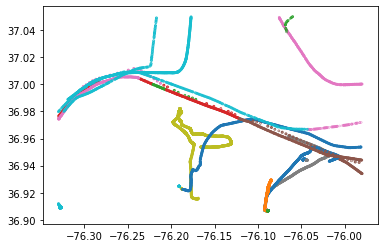

In [32]:
all_vessels = new_tracker.get_node_track()
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, new_tracker.get_track_number()))
for i in range(new_tracker.get_track_number()):
    track = all_vessels[i]
    temp_x = np.zeros(len(track))
    temp_y = np.zeros(len(track))
    counter = 0
    for element in track:
        temp_x[counter] = element.get_LON()
        temp_y[counter]= element.get_LAT()
        counter += 1
    x = np.array(temp_x)
    y = np.array(temp_y)
    plt.scatter(x,y, colors[i],linewidths=2)

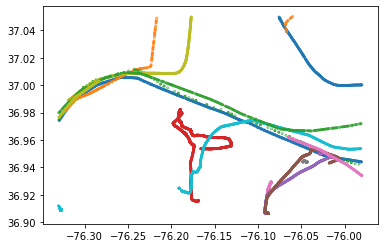

In [33]:
#Glimpse at all the vessel tracks
colors = cm.rainbow(np.linspace(0, 1, tracker.get_track_number()))
i = 0
for vid in range(low_bound, high_bound+1):
    sample = dataset[dataset.VID == vid]
    temp_x = [element.LAT for element in sample.itertuples()]
    temp_y = [element.LON for element in sample.itertuples()]
    x = np.array(temp_x)
    y = np.array(temp_y)
    plt.scatter(y,x, colors[i], linewidths=2)
    i += 1

In [34]:
result = new_tracker.get_tracks()
expect = tracker.get_tracks()
accuracies = []
for every_expect in expect:
    max_accuracy = 0
    count = 0
    for every_track in result:
        for every_node in every_expect:
            if every_node in every_track:
                count += 1
        accuracy = count / len(every_expect)
        count = 0
        if(accuracy > max_accuracy):
            max_accuracy = accuracy
    accuracies.append(max_accuracy)
            

In [35]:
print(accuracies)
print(sum(accuracies)/len(accuracies))

[0.39070567986230637, 1.0, 0.3918918918918919, 1.0, 0.39621267297887836, 0.42780337941628266, 0.35120481927710845, 0.3006885998469778, 1.0, 0.903420523138833, 1.0, 1.0, 0.8447488584474886, 0.323943661971831, 0.2616933096506809, 0.9083431257344301, 0.5028901734104047, 0.5, 1.0, 1.0]
0.6751773347813557
